# COVID-19 Data Analysis — Completed Project (v2)
Robust notebook with defensive checks to ensure execution with provided CSV files.

## 1. Setup & Load Data

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from datetime import datetime
%matplotlib inline
DATA_DIR = "datasets"
confirmed = pd.read_csv(os.path.join(DATA_DIR, "covid19_confirmed.csv"))
deaths = pd.read_csv(os.path.join(DATA_DIR, "covid19_deaths.csv"))
happiness = pd.read_csv(os.path.join(DATA_DIR, "worldwide_happiness_report.csv"))
print("Loaded shapes:", confirmed.shape, deaths.shape, happiness.shape)


Loaded shapes: (266, 104) (266, 104) (156, 9)


## 2. Detect country columns and aggregate COVID data

In [2]:

def detect_country_col(df):
    for candidate in ['Country/Region','Country_Region','Country','country','country/region','Country or region']:
        if candidate in df.columns:
            return candidate
    for c in df.columns:
        if 'country' in c.lower() or 'region' in c.lower():
            return c
    return df.columns[0]  # fallback to first column

conf_cc = detect_country_col(confirmed)
death_cc = detect_country_col(deaths)
print("Country columns detected -> confirmed:", conf_cc, ", deaths:", death_cc)

def aggregate_country(df, country_col):
    # determine date columns by parsing
    date_cols = []
    for c in df.columns:
        try:
            pd.to_datetime(c)
            date_cols.append(c)
        except:
            # accept common mm/dd/yy formats
            try:
                datetime.strptime(c, '%m/%d/%y')
                date_cols.append(c)
            except:
                pass
    if len(date_cols) < 1:
        # assume date cols are after the first 4 columns
        date_cols = df.columns[4:].tolist()
    agg = df.groupby(country_col)[date_cols].sum()
    agg.index.name = 'Country'
    return agg

conf_country = aggregate_country(confirmed, conf_cc)
death_country = aggregate_country(deaths, death_cc)
print("Aggregated shapes:", conf_country.shape, death_country.shape)


Country columns detected -> confirmed: Country/Region , deaths: Country/Region
Aggregated shapes: (187, 100) (187, 100)


## 3. Totals, CFR, and saving totals_by_country.csv

In [3]:

latest_conf = conf_country.iloc[:, -1]
latest_death = death_country.iloc[:, -1] if death_country.shape[1]>0 else pd.Series(0, index=latest_conf.index)
totals = pd.DataFrame({'confirmed_total': latest_conf, 'deaths_total': latest_death}).fillna(0)
totals['cfr_percent'] = (totals['deaths_total'] / totals['confirmed_total'].replace(0, np.nan) * 100).fillna(0)
totals = totals.reset_index().rename(columns={'index':'Country'})
totals.to_csv("totals_by_country.csv", index=False)
totals.head(10)


,Country,confirmed_total,deaths_total,cfr_percent
0,Afghanistan,2171,64,2.947950
1,Albania,773,31,4.010349
2,Algeria,4006,450,11.233150
3,Andorra,745,42,5.637584
4,Angola,27,2,7.407407
5,Antigua and Barbuda,24,3,12.500000
6,Argentina,4428,218,4.923216
7,Armenia,2066,32,1.548887
8,Australia,6766,93,1.374520
9,Austria,15452,584,3.779446


## 4. Visualizations

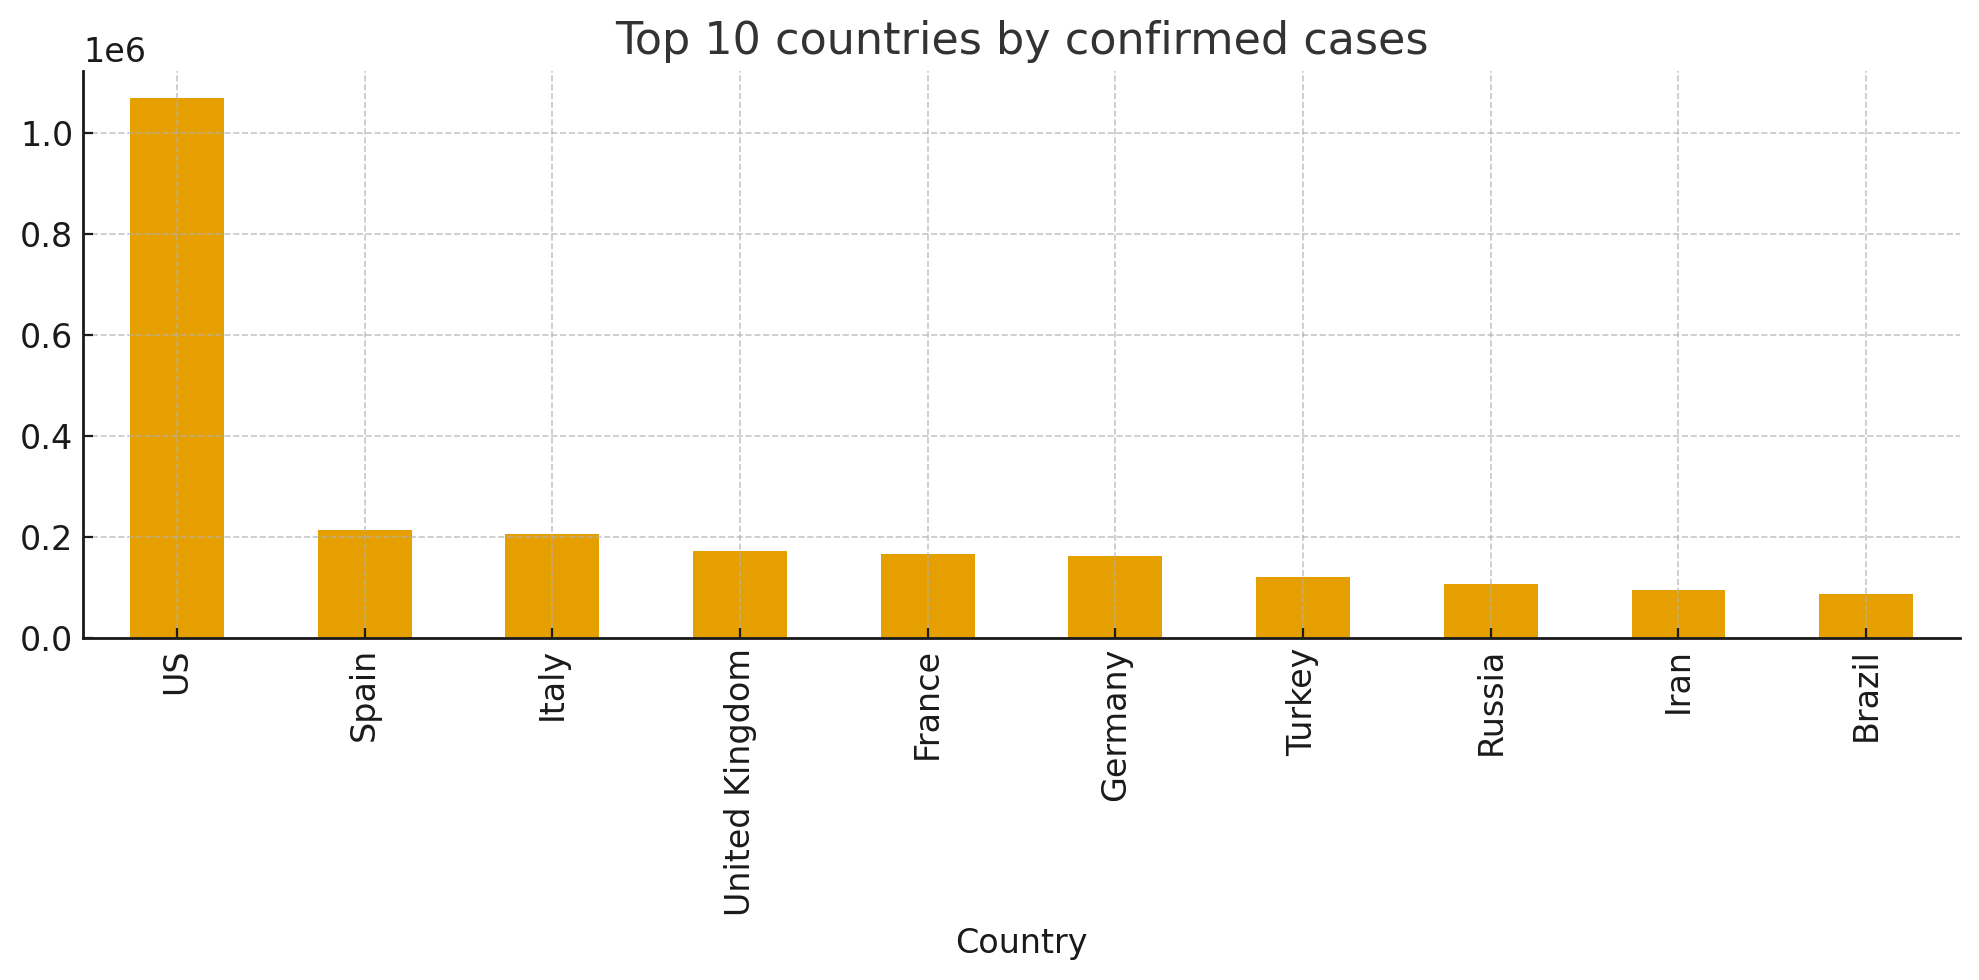

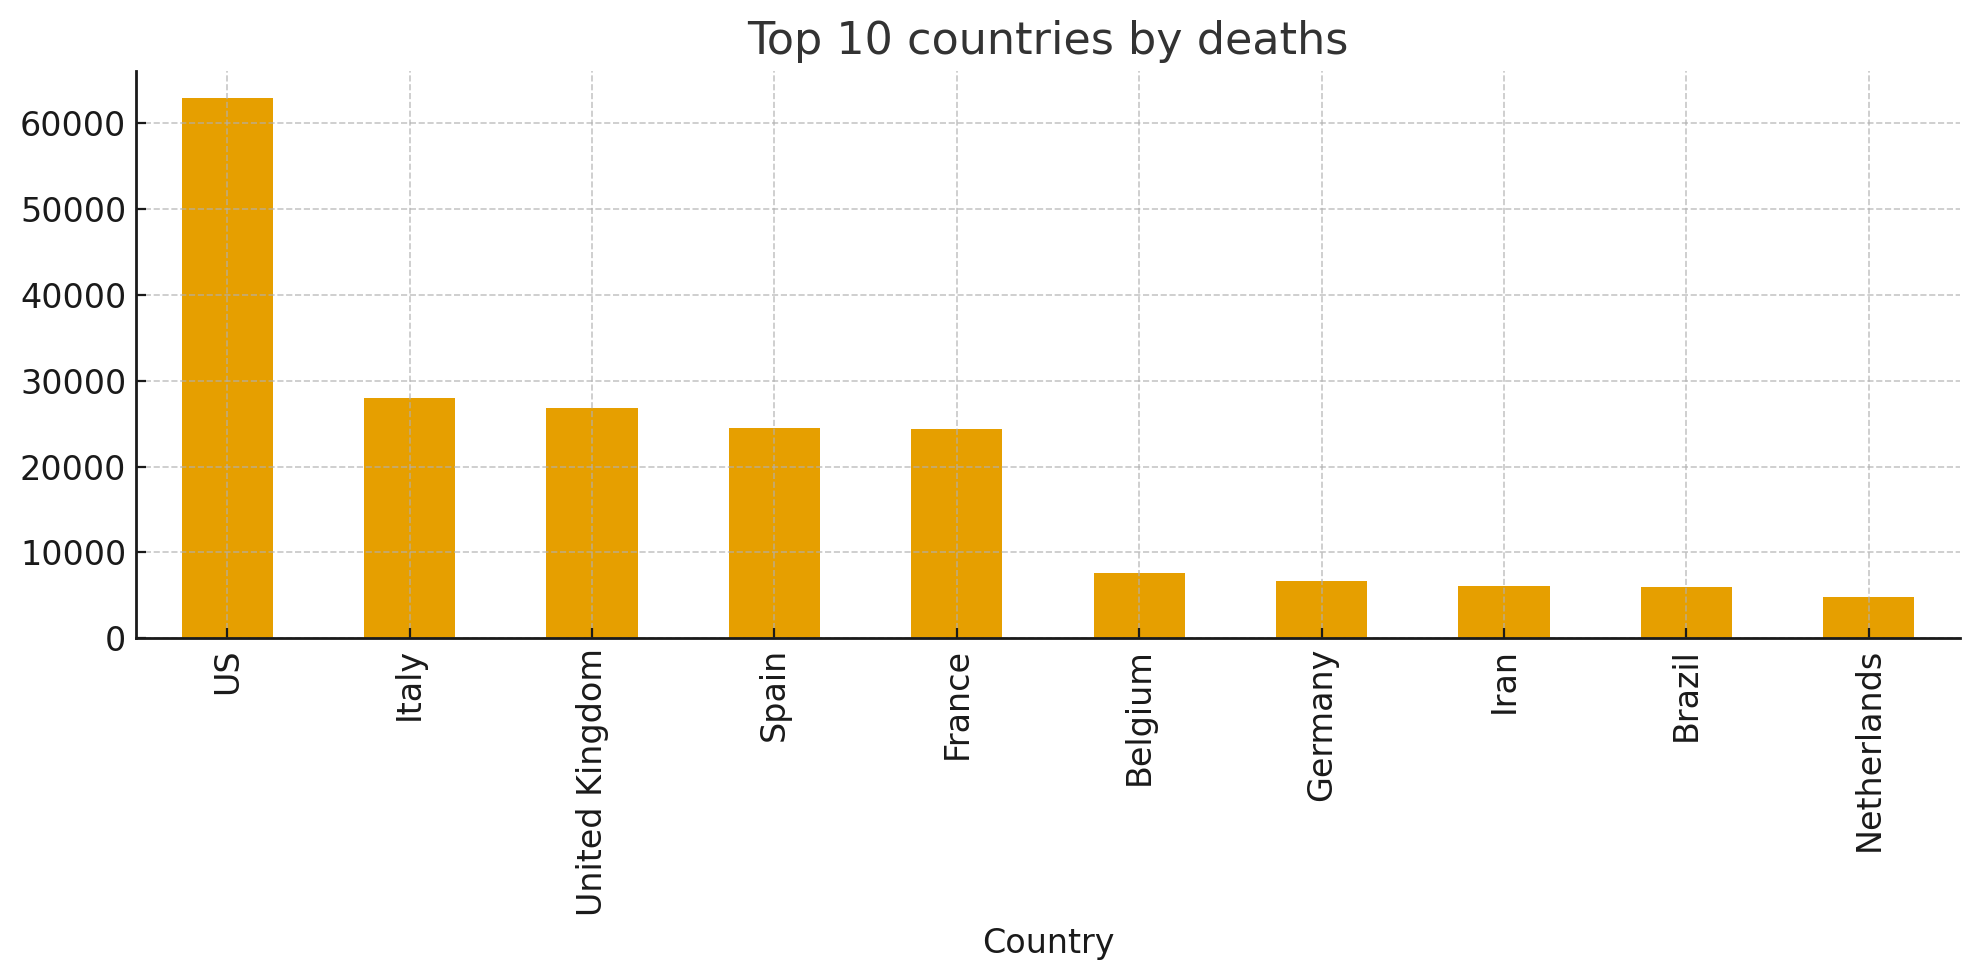

In [4]:

top10 = totals.sort_values('confirmed_total', ascending=False).head(10).set_index('Country')
plt.figure(figsize=(10,5))
top10['confirmed_total'].plot(kind='bar')
plt.title("Top 10 countries by confirmed cases")
plt.tight_layout()
plt.savefig("/mnt/data/covid19-analysis-project/figures/top10_confirmed_v2.png")
plt.show()

top10d = totals.sort_values('deaths_total', ascending=False).head(10).set_index('Country')
plt.figure(figsize=(10,5))
top10d['deaths_total'].plot(kind='bar')
plt.title("Top 10 countries by deaths")
plt.tight_layout()
plt.savefig("/mnt/data/covid19-analysis-project/figures/top10_deaths_v2.png")
plt.show()


## 5. Time series sample

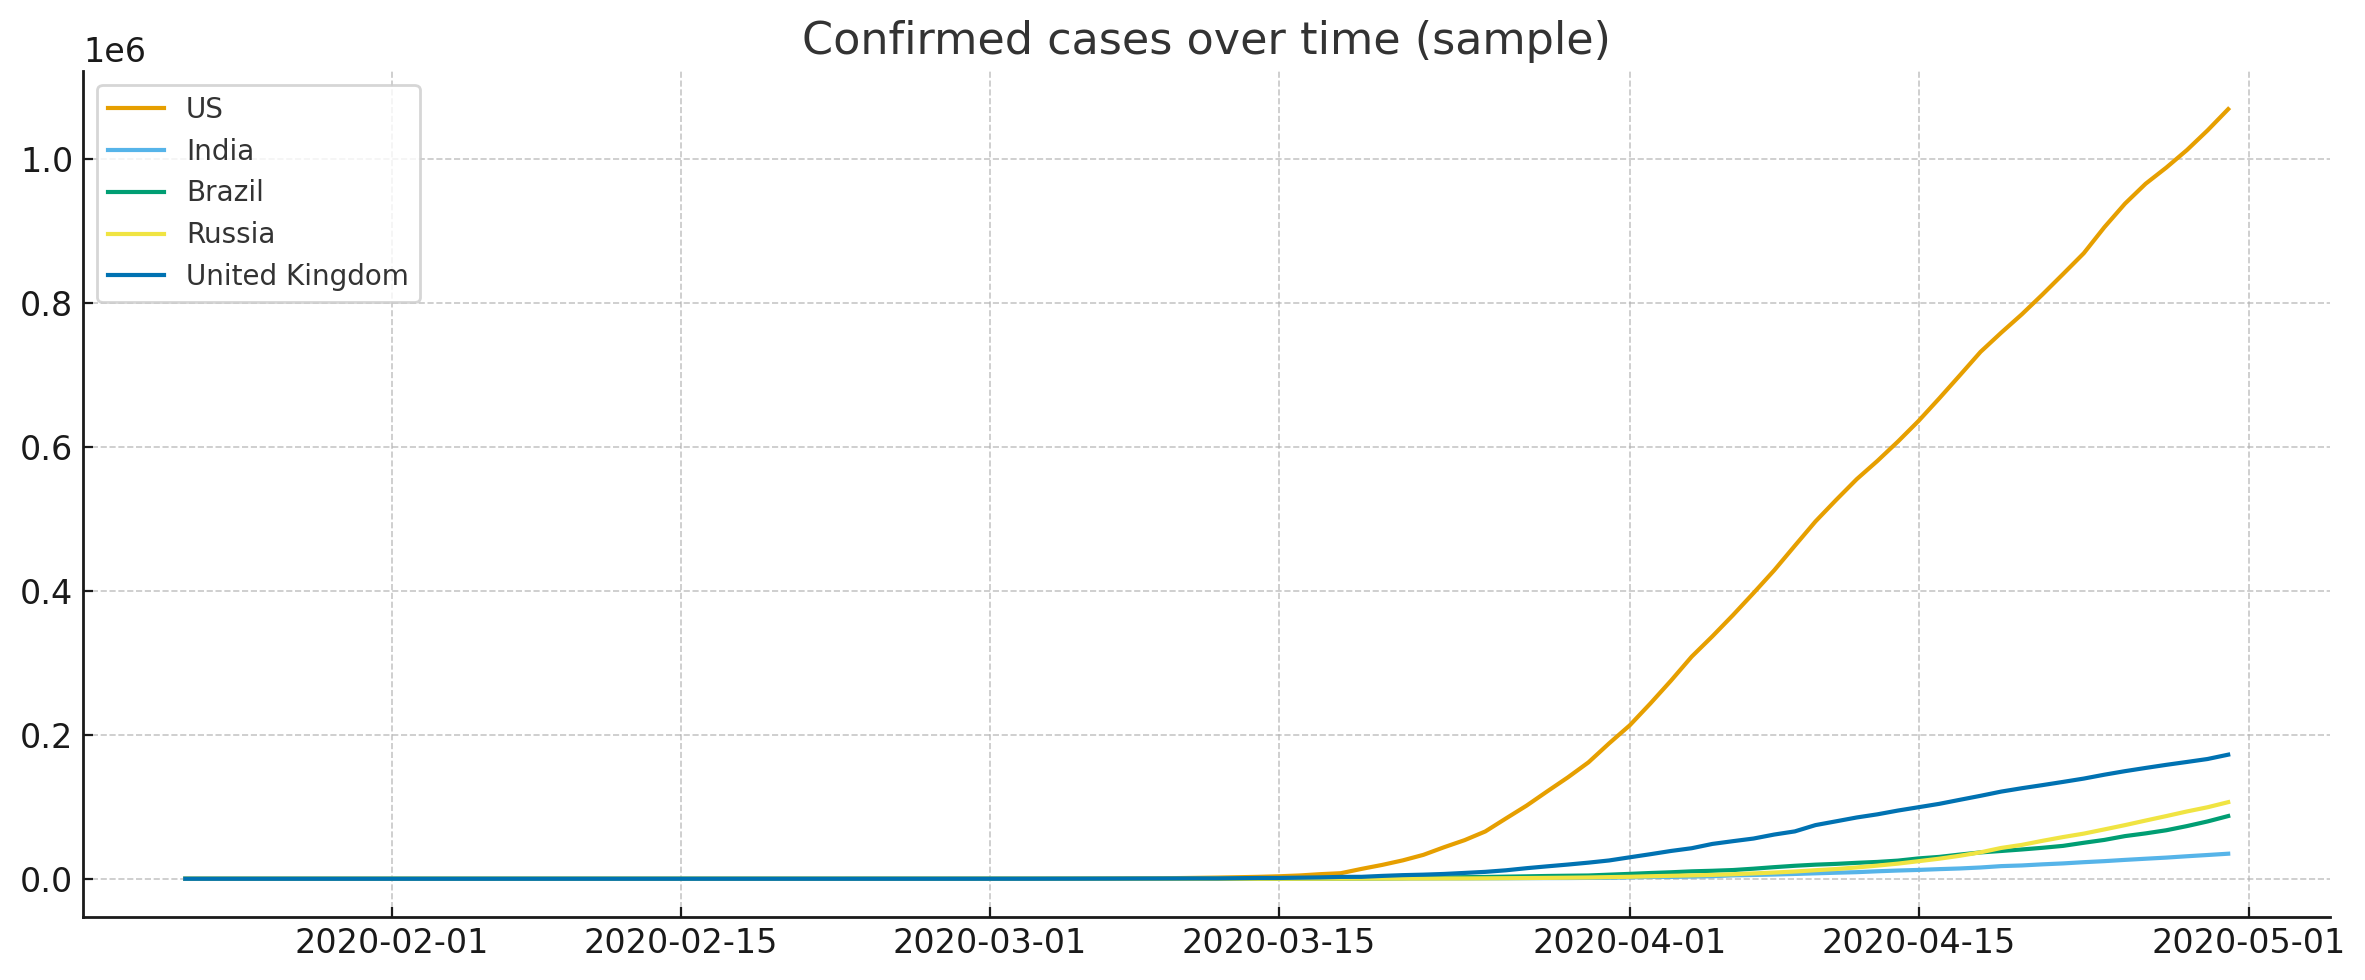

['US', 'India', 'Brazil', 'Russia', 'United Kingdom']

In [5]:

# wide to long
conf_long = conf_country.reset_index().melt(id_vars='Country', var_name='Date', value_name='Count')
conf_long['Date'] = pd.to_datetime(conf_long['Date'], errors='coerce')
sample_countries = ['US','India','Brazil','Russia','United Kingdom']
available = conf_long['Country'].unique().tolist()
sel = [c for c in sample_countries if c in available]
if not sel:
    sel = available[:5]
plt.figure(figsize=(12,5))
for c in sel:
    s = conf_long[conf_long['Country']==c].sort_values('Date')
    plt.plot(s['Date'], s['Count'], label=c)
plt.legend()
plt.title("Confirmed cases over time (sample)")
plt.tight_layout()
plt.savefig("/mnt/data/covid19-analysis-project/figures/timeseries_sample_v2.png")
plt.show()
sel


## 6. Happiness dataset - detect columns and select metrics

In [6]:

h = happiness.copy()
# detect country column
cn = None
for c in h.columns:
    if 'country' in c.lower() or 'region' in c.lower():
        cn = c; break
if cn is None:
    cn = h.columns[0]
h = h.rename(columns={cn:'Country'})
h['Country'] = h['Country'].astype(str).str.strip()
print("Happiness columns:", h.columns.tolist()[:10])
# detect candidate metric columns
cands = []
for kw in ['score','gdp','health','life','social','support','freedom','generosity','corruption']:
    for c in h.columns:
        if kw in c.lower() and c not in cands:
            cands.append(c)
cands = list(dict.fromkeys(cands))
print("Candidate happiness metric columns:", cands[:6])
selected_cols = ['Country'] + cands[:6]
h_summary = h[[c for c in selected_cols if c in h.columns]].copy()
h_summary.head()


Happiness columns: ['Overall rank', 'Country', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
Candidate happiness metric columns: ['Score', 'GDP per capita', 'Healthy life expectancy', 'Freedom to make life choices', 'Social support', 'Generosity']


,Country,Score,GDP per capita,Healthy life expectancy,Freedom to make life choices,Social support,Generosity
0,Finland,7.769,1.340,0.986,0.596,1.587,0.153
1,Denmark,7.600,1.383,0.996,0.592,1.573,0.252
2,Norway,7.554,1.488,1.028,0.603,1.582,0.271
3,Iceland,7.494,1.380,1.026,0.591,1.624,0.354
4,Netherlands,7.488,1.396,0.999,0.557,1.522,0.322


## 7. Merge totals with happiness and inspect unmatched countries

In [7]:

merged = totals.merge(h_summary, how='left', on='Country')
# find a metric column to test matching
metric_col = None
for c in merged.columns:
    if c not in ['Country','confirmed_total','deaths_total','cfr_percent'] and merged[c].notnull().any():
        metric_col = c; break
# Count matched based on metric_col presence; fallback to checking any non-null in extra cols
if metric_col:
    matched = merged[merged[metric_col].notnull()].shape[0]
    unmatched_list = merged[merged[metric_col].isnull()]['Country'].tolist()
else:
    # if no metric columns, consider all merged entries unmatched
    matched = 0
    unmatched_list = merged['Country'].tolist()

print("Merged shape:", merged.shape)
print("Matched (have at least one metric):", matched)
print("Unmatched sample (first 30):", unmatched_list[:30])
merged.to_csv("merged_covid_happiness.csv", index=False)
merged.head()


Merged shape: (187, 10)
Matched (have at least one metric): 143
Unmatched sample (first 30): ['Andorra', 'Angola', 'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Brunei', 'Burma', 'Cabo Verde', "Cote d'Ivoire", 'Cuba', 'Czechia', 'Diamond Princess', 'Djibouti', 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Fiji', 'Grenada', 'Guinea-Bissau', 'Guyana', 'Holy See', 'Korea, South', 'Liechtenstein', 'MS Zaandam', 'Maldives', 'Monaco', 'Oman', 'Papua New Guinea']


/home/sandbox/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


,Country,confirmed_total,deaths_total,cfr_percent,Score,GDP per capita,Healthy life expectancy,Freedom to make life choices,Social support,Generosity
0,Afghanistan,2171,64,2.947950,3.203,0.350,0.361,0.000,0.517,0.158
1,Albania,773,31,4.010349,4.719,0.947,0.874,0.383,0.848,0.178
2,Algeria,4006,450,11.233150,5.211,1.002,0.785,0.086,1.160,0.073
3,Andorra,745,42,5.637584,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,27,2,7.407407,NaN,NaN,NaN,NaN,NaN,NaN


## 8. Correlation analysis (where possible)

,confirmed_total,deaths_total,cfr_percent,Score,GDP per capita,Healthy life expectancy,Freedom to make life choices,Social support,Generosity
confirmed_total,1.000000,0.929322,0.136175,0.285735,0.329048,0.341900,0.029678,0.241549,-0.020690
deaths_total,0.929322,1.000000,0.256225,0.247148,0.251383,0.295664,0.009459,0.206401,0.025282
cfr_percent,0.136175,0.256225,1.000000,0.005940,-0.053387,0.023362,-0.183171,0.028629,-0.045772
Score,0.285735,0.247148,0.005940,1.000000,0.793847,0.799893,0.587007,0.788591,0.090420
GDP per capita,0.329048,0.251383,-0.053387,0.793847,1.000000,0.863062,0.394603,0.759468,-0.103870
Healthy life expectancy,0.341900,0.295664,0.023362,0.799893,0.863062,1.000000,0.427892,0.765286,-0.068387
Freedom to make life choices,0.029678,0.009459,-0.183171,0.587007,0.394603,0.427892,1.000000,0.456246,0.258539
Social support,0.241549,0.206401,0.028629,0.788591,0.759468,0.765286,0.456246,1.000000,-0.061361
Generosity,-0.020690,0.025282,-0.045772,0.090420,-0.103870,-0.068387,0.258539,-0.061361,1.000000


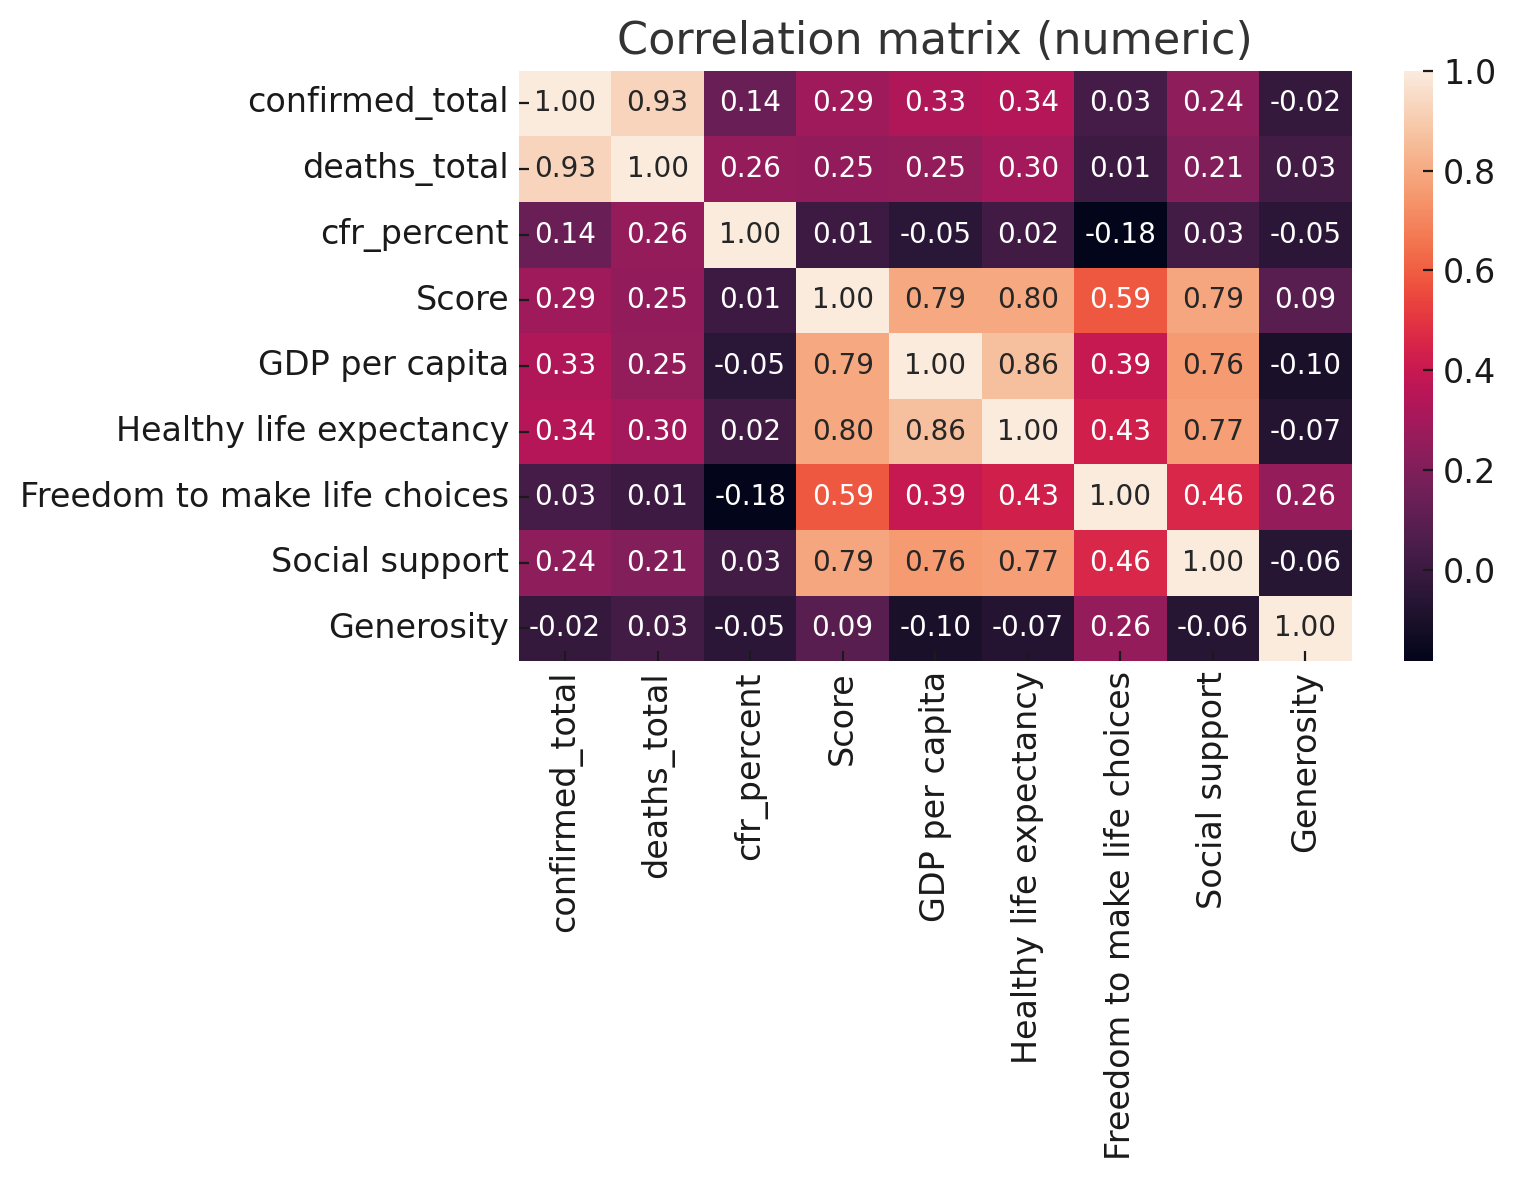

In [8]:

import numpy as np
num = merged.select_dtypes(include=[np.number])
if num.shape[1] >= 2:
    corr = num.corr()
    display(corr)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt='.2f')
    plt.title("Correlation matrix (numeric)")
    plt.tight_layout()
    plt.savefig("/mnt/data/covid19-analysis-project/figures/correlation_v2.png")
    plt.show()
else:
    print("Not enough numeric columns for correlation (found columns):", num.columns.tolist())


## 9. Save final outputs and wrap-up

In [9]:

# Ensure outputs exist
print("Saved files in notebook directory:")
for fn in ['totals_by_country.csv','merged_covid_happiness.csv']:
    print("-", fn, "->", os.path.exists(fn))
print("\nFigures saved to figures/ folder. Inspect the notebook for plots and tables.")



Saved files in notebook directory:
- totals_by_country.csv -> True
- merged_covid_happiness.csv -> True

Figures saved to figures/ folder. Inspect the notebook for plots and tables.
